In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

url = r'https://data.nsw.gov.au/data/dataset/aefcde60-3b0c-4bc0-9af1-6fe652944ec2/resource/21304414-1ff1-4243-a5d2-f52778048b29/download/confirmed_cases_table1_location.csv'
data = pd.read_csv(url)

#rename some columns, and get relevant columns into dataframe
data = data.rename(columns={"notification_date":"date","lga_name19":"lga","lhd_2010_name":"district"})
data = data[["date","postcode","lga","district"]]

#Some data has NaN value as the location of covid-19 is untraceable
#Postcode is float type atm, change to text
data["postcode"] = data["postcode"].fillna(9999)
data["lga"] = data["lga"].fillna("Unknown")
data["district"] = data["district"].fillna("Unknown")
data["postcode"]= data["postcode"].astype(object)
data["date"]= pd.to_datetime(data["date"])

#create date type columns
data["day"] = data["date"].dt.day
data["month"] = data["date"].dt.month
data["year"] = data["date"].dt.year
data["dayofweek"] = data["date"].dt.day_name()

data

,date,postcode,lga,district,day,month,year,dayofweek
0,2020-01-25,2134,Burwood (A),Sydney,25,1,2020,Saturday
1,2020-01-25,2121,Parramatta (C),Northern Sydney,25,1,2020,Saturday
2,2020-01-25,2071,Ku-ring-gai (A),Northern Sydney,25,1,2020,Saturday
3,2020-01-27,2033,Randwick (C),South Eastern Sydney,27,1,2020,Monday
4,2020-03-01,2163,Fairfield (C),South Western Sydney,1,3,2020,Sunday
...,...,...,...,...,...,...,...,...
4807,2021-01-08,2160,Cumberland (A),Western Sydney,8,1,2021,Friday
4808,2021-01-08,2564,Campbelltown (C) (NSW),South Western Sydney,8,1,2021,Friday
4809,2021-01-08,9999,Unknown,Unknown,8,1,2021,Friday
4810,2021-01-08,2211,Canterbury-Bankstown (A),South Western Sydney,8,1,2021,Friday


# ================== EDA ==================

# EDA with date

In [2]:
#get a new dataset with date only
columns = ["date","day","month","year","dayofweek"]
datedata = data.loc[:,columns]

#create new dataset with cases and cumulative count
dailycases= datedata.groupby(["date","day","month","year","dayofweek"])["date"].count().reset_index(name="cases")
dailycases["culmulative"] = dailycases["cases"].cumsum()

dailycases

,date,day,month,year,dayofweek,cases,culmulative
0,2020-01-25,25,1,2020,Saturday,3,3
1,2020-01-27,27,1,2020,Monday,1,4
2,2020-03-01,1,3,2020,Sunday,2,6
3,2020-03-02,2,3,2020,Monday,3,9
4,2020-03-03,3,3,2020,Tuesday,6,15
...,...,...,...,...,...,...,...
299,2021-01-04,4,1,2021,Monday,4,4785
300,2021-01-05,5,1,2021,Tuesday,4,4789
301,2021-01-06,6,1,2021,Wednesday,12,4801
302,2021-01-07,7,1,2021,Thursday,5,4806


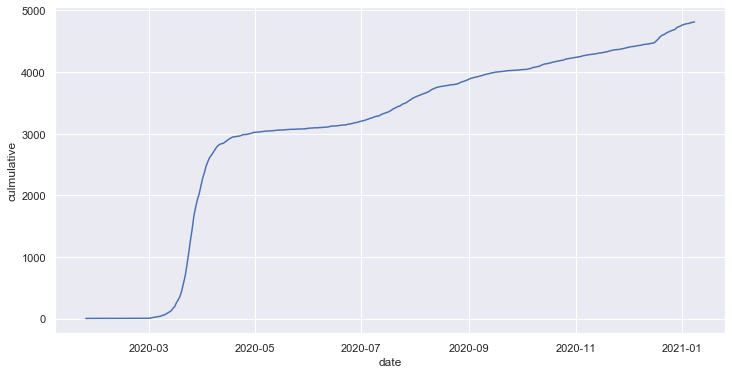

In [3]:
#Plot to see cumululative cases
sns.set(rc={'figure.figsize':(12,6)})
sns.lineplot(x=dailycases["date"],y=dailycases["culmulative"])

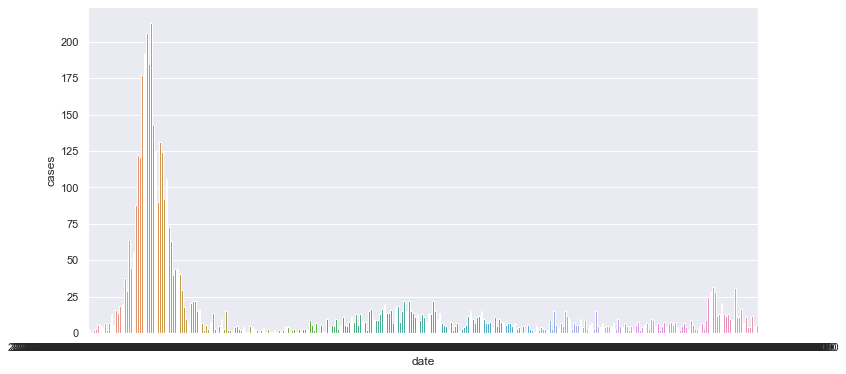

In [4]:
#Plot into barchart
sns.barplot(x=dailycases["date"],y=dailycases["cases"])
plt.show()

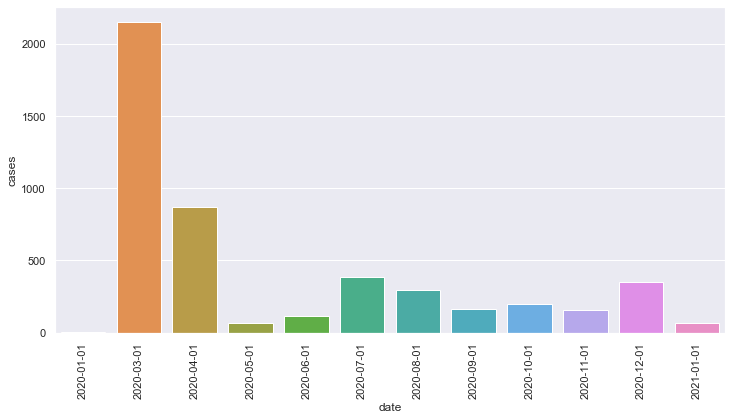

In [5]:
#monthly cases figure
monthlycases = dailycases.loc[:,["cases","month","year"]]
monthlycases = monthlycases.groupby(["month","year"])["cases"].sum().reset_index(name="cases")
monthlycases["date"]=pd.to_datetime(monthlycases[["year","month"]].assign(DAY=1)).dt.date
monthlycases = monthlycases.drop(columns = {"month","year"})
monthlycases.sort_values(by=["date"], inplace = True)

#monthly cases bar chart
chrt = sns.barplot(x=monthlycases["date"], y=monthlycases["cases"])
chrt.set_xticklabels(chrt.get_xticklabels(), rotation = 90)
plt.show()

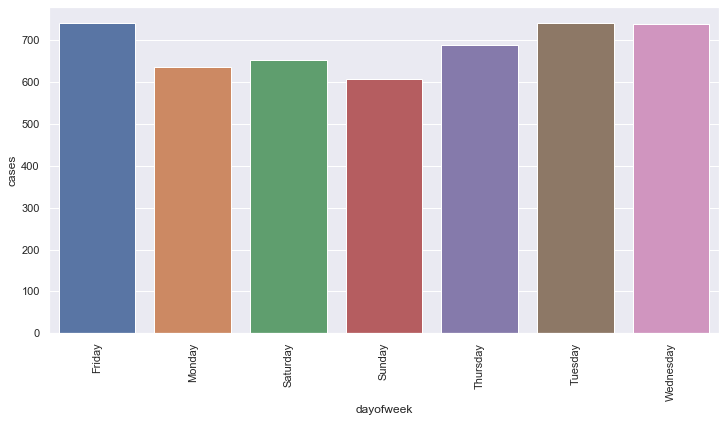

In [6]:
#cases by date of a week
weekdaycases = dailycases.loc[:,["cases","dayofweek"]]
weekdaycases = weekdaycases.groupby(["dayofweek"])["cases"].sum().reset_index(name="cases")

#plot to see which day has most cases
chrt = sns.barplot(x=weekdaycases["dayofweek"], y=weekdaycases["cases"])
chrt.set_xticklabels(chrt.get_xticklabels(), rotation = 90)
plt.show()

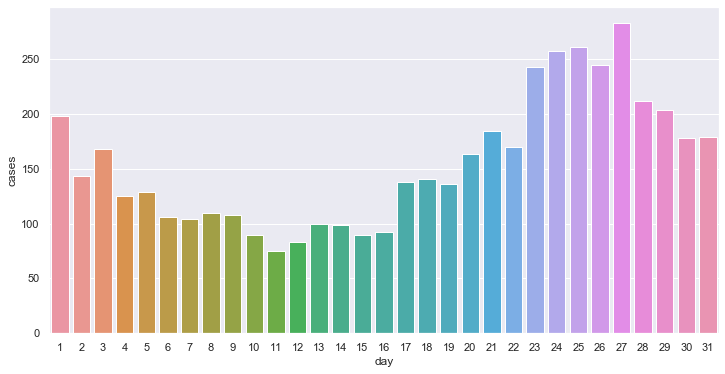

In [7]:
#cases by day
daycases = dailycases.loc[:,["day","cases"]]
daycases = daycases.groupby(["day"])["cases"].sum().reset_index(name="cases")

#plot to see which day has most cases
chrt = sns.barplot(x=daycases["day"], y=daycases["cases"])
plt.show()

# EDA with location

In [8]:
#Group data by lga
lgadata = data.groupby(["lga"])["lga"].count().reset_index(name="count")
lgadata = lgadata.sort_values(by=["count"], ascending= False)

#no need for unknown data
lgadata = lgadata[lgadata["lga"]!="Unknown"]
lgadata

,lga,count
66,Northern Beaches (A),283
97,Waverley (A),224
84,Sydney (C),213
25,Cumberland (A),206
8,Blacktown (C),205
...,...,...
44,Junee (A),1
63,Narromine (A),1
62,Narrandera (A),1
60,Muswellbrook (A),1


[]

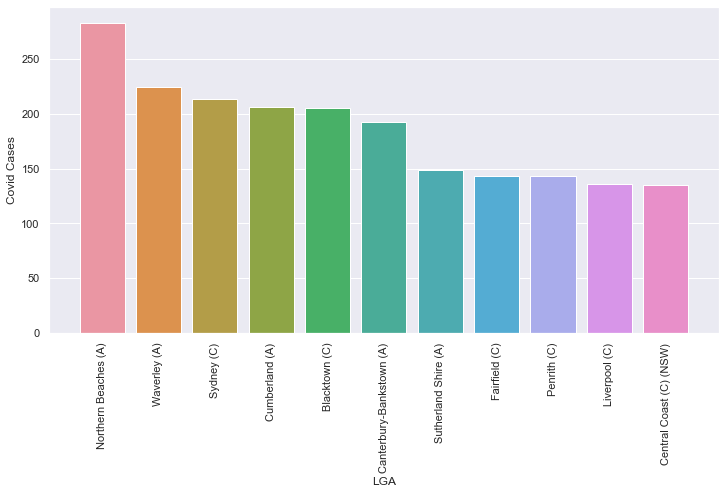

In [9]:
#get top 10 lga that has most cases and not include unknown
lgadata = lgadata.iloc[:11]
chrt = sns.barplot(x=lgadata["lga"], y=lgadata["count"])
chrt.set_xticklabels(chrt.get_xticklabels(), rotation=90)
chrt.set(xlabel="LGA",ylabel= "Covid Cases")

chrt.plot()

In [10]:
#Group data by district
district = data.groupby(["district"])["district"].count().reset_index(name="count")
district = district.sort_values(by=["count"],ascending = False)

#no need for unknown location
district = district[district["district"] != "Unknown"]
district

,district,count
10,South Eastern Sydney,867
9,Northern Sydney,755
16,Western Sydney,614
11,South Western Sydney,595
13,Sydney,383
2,Hunter New England,309
6,Nepean Blue Mountains,211
3,Illawarra Shoalhaven,148
0,Central Coast,135
12,Southern NSW,74


[]

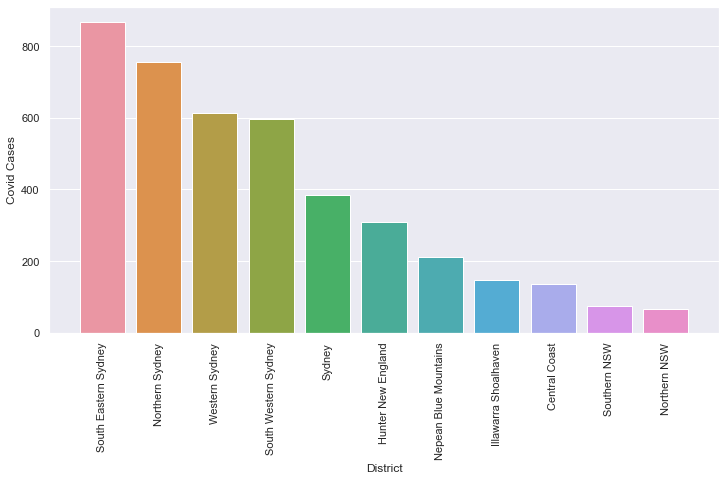

In [11]:
#get top 10 district that has most covid19 cases
district = district.iloc[:11]
chrt = sns.barplot(x=district["district"], y=district["count"])
chrt.set_xticklabels(chrt.get_xticklabels(), rotation=90)
chrt.set(xlabel="District",ylabel= "Covid Cases")

chrt.plot()